# Traffic Sign Recognition

The Dataset: 

# Initialization

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pathlib
import os
import timeit
import itertools

# Keras
from keras.utils.np_utils import to_categorical
from keras import metrics
# tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model

# cv2
import cv2

# sklearn
from sklearn.metrics import confusion_matrix

# MLOps
import wandb
from wandb.keras import WandbCallback

# General Parameters

In [2]:
# get num of classes
def get_num_classes(path):
    num_cats = 0
    for fname in os.listdir(path):
        try:
            bool = type(int(fname)) is int
            num_cats +=1
        except:
            pass
    return num_cats

In [3]:
# location of the data
base_dir = './dataset/GTSRB'
train_dir = './dataset/GTSRB/Train'
test_dir = './dataset/GTSRB/Test'

# dataset metadata
train_meta = './dataset/GTSRB/Train.csv'
test_meta = './dataset/GTSRB/Test.csv'

## Helper Functions

In [58]:
def plot_results(history, simple_style=False):
    # Results analysis:
    if simple_style:
        losses = pd.DataFrame(history.history, columns=['loss', 'val_loss'])
        accuracies = pd.DataFrame(history.history, columns=['acc', 'val_acc'])
        losses.plot()
        accuracies.plot()
    else:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, color='blue', label='Training acc')
        plt.plot(epochs, val_acc, color='gray', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
        plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()

# plots images with labels within jupyter notebook
# source: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py#L79

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

# plot Confusion Matrix
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def get_input_img(sign_class, img_height, img_width, index = 0, dataset='Test'):
    def reshape_img(img):
        img = cv2.resize(img, (img_height,img_width))
        return np.expand_dims(img, axis=0)

    if dataset == 'Train':
        file_path = base_dir + '/Train/' + str(sign_class) + '/'
        file_name = os.listdir(file_path)[index]
        img = cv2.imread(file_path + file_name)
    
    if dataset == 'Test':
        meta = pd.read_csv('./dataset/GTSRB/Test.csv')
        file = meta[meta['ClassId'] == sign_class]['Path'].values[index]
        img = cv2.imread(base_dir + '/' + file)        

    plt.imshow(img)
    return reshape_img(img)
        

def plot_feature_maps(model, img):
    successive_outputs = [layer.output for layer in model.layers[1:]]
    inputs = model.inputs
    outputs = successive_outputs
    filters = Model(inputs=inputs, outputs=outputs)
    feature_maps = filters.predict(img)
    layer_names = [layer.name for layer in model.layers]
    for layer_name, feature_map in zip(layer_names, feature_maps):
        print(feature_map.shape)
        if len(feature_map.shape) == 4:
            # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
            n_features = feature_map.shape[-1]  # number of features in the feature map
            size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
            # We will tile our images in this matrix
            display_grid = np.zeros((size, size * n_features))
            
            for i in range(n_features):
                x = feature_map[0, :, :, i]
                x -= x.mean()
                x /= x.std()
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                display_grid[:, i * size : (i + 1) * size] = x

            #Display the grid
            scale = 20. / n_features
            plt.figure( figsize=(scale * n_features, scale) )
            plt.title ( layer_name )
            plt.grid  ( False )
            plt.imshow( display_grid, aspect='auto', cmap='viridis' )
        

## MLOps

Weights an Biases init

In [5]:
!wandb login

wandb: Currently logged in as: gaspia (use `wandb login --relogin` to force relogin)


In [6]:
#Generic dataset parameters
img_width, img_height = 32, 32
batch_size = 256
cat_num = get_num_classes(train_dir)

# Dataset exploration and preprocessing

In [7]:
# training dataset

def get_train_val_data(train_dir, img_width, img_height, batch_size, seed):
    #training dataset
    train_datagen = ImageDataGenerator(validation_split=0.3, rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='training',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',    
        shuffle=True,
        seed=seed,
        class_mode='categorical')

    # validation dataset
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='validation',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',    
        seed=seed,
        class_mode='categorical'
        )

    return train_generator, val_generator

def get_test_data(test_dir, labels_path, img_width, img_height, batch_size):
    #test dataset
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(labels_path, dtype=str),
        directory = test_dir,
        x_col = 'Path',
        y_col = 'ClassId',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical'
        )
    
    return test_generator

In [8]:
train_generator, val_generator = get_train_val_data(train_dir, img_width, img_height, batch_size, seed=1)

Found 27447 images belonging to 43 classes.
Found 11762 images belonging to 43 classes.


In [9]:
test_generator = get_test_data(base_dir, test_meta, img_width, img_height, batch_size)

Found 12630 validated image filenames belonging to 43 classes.


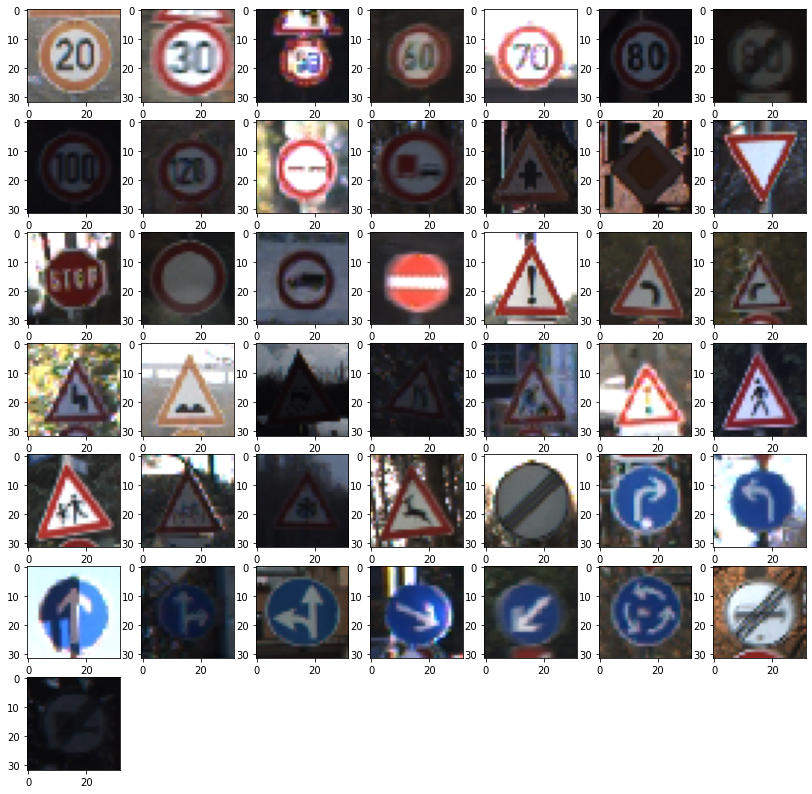

In [10]:
# Visualizing all the different Signs
img_dir = pathlib.Path(train_dir)
plt.figure(figsize=(14,14))
index = 0
for i in range(cat_num):
    plt.subplot(7, 7, i+1)
    plt.grid(False)
    sign = list(img_dir.glob(f'{i}/*'))[0]
    img = load_img(sign, target_size=(img_width, img_height))
    plt.imshow(img)
plt.show()

## Class Distribution

In [11]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

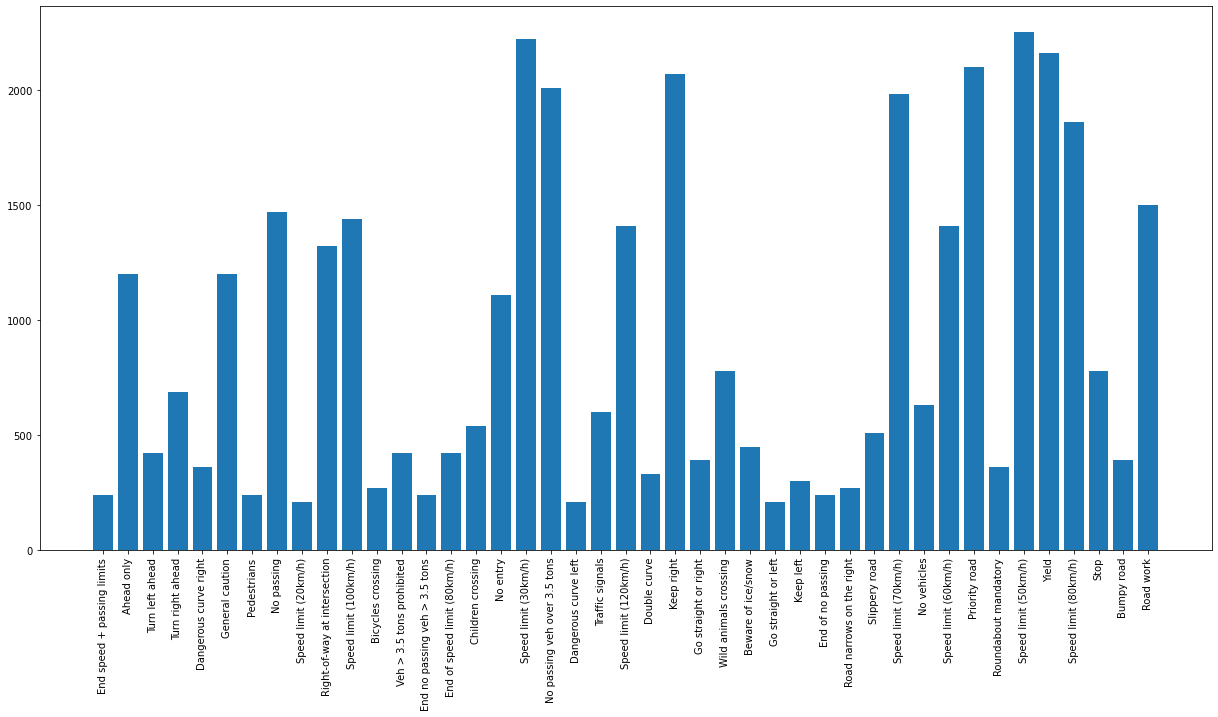

In [12]:
# determining the training data distribution per category
folders = next(os.walk(train_dir))[1]

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_dir + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

## Analysis of the dataset

1. We can tell the image size is 
2. Some of the images have issues with low lighting / contrast / saturation which may become a problem for the model
3. The data is highly unbalanced

# Model Architectures

## Generic Paramters

In [13]:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num
}

## Baseline

The first CNN we are going to build consists on the following: 
1. A Convolutional layer followed by a MaxPooling layer; 
2. A second Convolutional layer followed by another MaxPooling layer; 
3. A Flatten layer (this is the input layer for the fully connected part of the CNN); 
4. A Dense Layer (this is the first hidden layer for the fully connected part of the CNN)
5. A second Dense layer (this is the output layer for the fully connected part of the CNN).
<br>

Please be mindful regarding the details below:
- The first and second Convolutional layers should contain 32 neurons (filters), with a filter of size 3x3 and an input shape of 64x64x3;
- The first and second MaxPooling layer should have a size of 2x2;
- The first Dense layer should have 128 neurons and the activation function should be the relu, while the second Dense layer should contain 1 neuron and the softmax as the activation function.

In [14]:
baseline_model = Sequential()
# Refference: DLNN lecture week 6
baseline_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(32, 32, 3)))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))
baseline_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))
# MLP - input layer
baseline_model.add(Flatten())
# MLP - hidden layer
baseline_model.add(Dense(units=128, activation=relu))
# MLP - output layer
baseline_model.add(Dense(units=43, activation=softmax))

# Check built model:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 128)               1

2022-01-06 19:17:52.075618: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training And Evaluating The Model

In [15]:
from tensorflow.keras import optimizers 

baseline_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [16]:
# Common attributes:
mlops_config['steps_per_epoch'] = 5
mlops_config['epochs'] = 100
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['metrics'] = ['acc']

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 5
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [18]:
# MLOps init and callback
wandb.init(name='CNN_TS_baseline_b256_e100' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_baseline = baseline_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gaspia (use `wandb login --relogin` to force relogin)
/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


Epoch 1/100
5/5 [==============================] - 21s 5s/step - loss: 3.7017 - acc: 0.0461 - val_loss: 3.5872 - val_acc: 0.0586
Epoch 2/100
5/5 [==============================] - 18s 4s/step - loss: 3.5754 - acc: 0.0570 - val_loss: 3.4996 - val_acc: 0.1117
Epoch 3/100
5/5 [==============================] - 17s 4s/step - loss: 3.4941 - acc: 0.1562 - val_loss: 3.4363 - val_acc: 0.1262
Epoch 4/100
5/5 [==============================] - 18s 4s/step - loss: 3.3771 - acc: 0.1586 - val_loss: 3.3469 - val_acc: 0.1443
Epoch 5/100
5/5 [==============================] - 16s 4s/step - loss: 3.3095 - acc: 0.1828 - val_loss: 3.2752 - val_acc: 0.1525
Epoch 6/100
5/5 [==============================] - 20s 5s/step - loss: 3.2543 - acc: 0.2016 - val_loss: 3.1911 - val_acc: 0.2041
Epoch 7/100
5/5 [==============================] - 15s 3s/step - loss: 3.1071 - acc: 0.2500 - val_loss: 3.0639 - val_acc: 0.2270
Epoch 8/100
5/5 [==============================] - 14s 3s/step - loss: 2.9278 - acc: 0.2820 - val

acc,▁▂▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▇▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time-elapsed,▁
val_acc,▁▂▂▃▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████
val_loss,██▇▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.95156
best_epoch,75
best_val_loss,0.69472
epoch,80
loss,0.23431


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7465/452919013.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7465/452919013.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


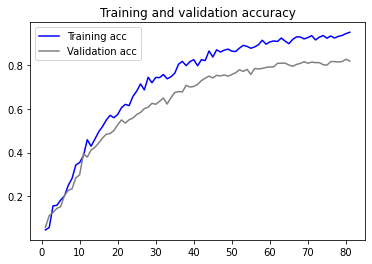

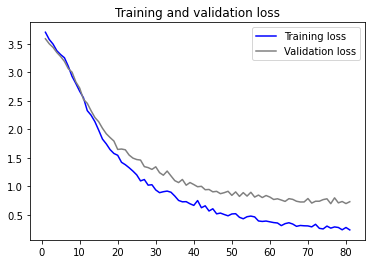

In [19]:
plot_results(history_baseline)

Confusion matrix, without normalization
[[ 1  5  5 ...  1  2  0]
 [ 0 47 43 ... 17 30 22]
 [ 2 40 34 ... 21 20 30]
 ...
 [ 1 33 33 ... 14 11  9]
 [ 2 24 17 ... 15  9 15]
 [ 0 25 33 ... 25 11 20]]


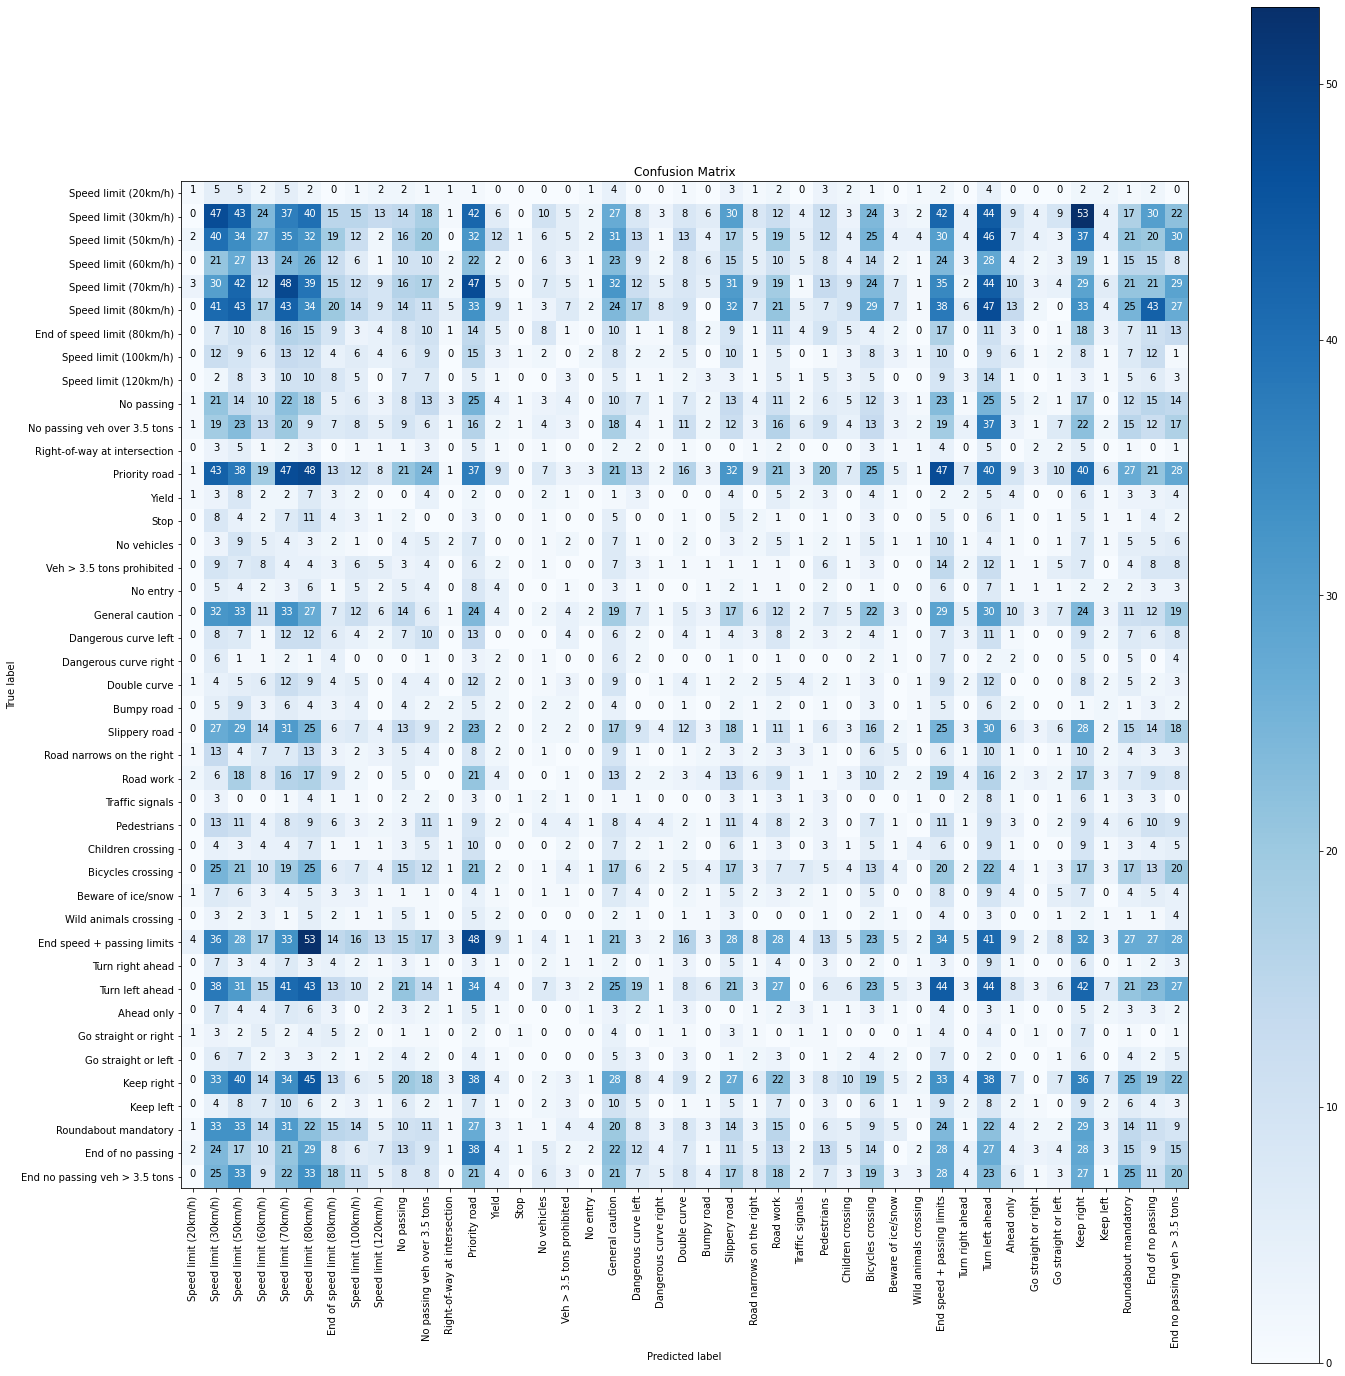

In [20]:
# predictions on Test data

Y_pred = baseline_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

Shape before entering the conv layer: (1, 32, 32, 3)


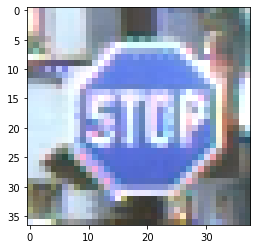

In [61]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 3, 'Test')
print ('Shape before entering the conv layer:', img.shape)

(1, 15, 15, 32)
(1, 13, 13, 32)
(1, 6, 6, 32)
(1, 1152)
(1, 128)
(1, 43)


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7465/2990367024.py:120: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


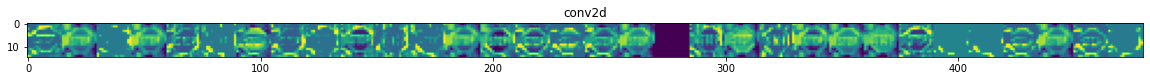

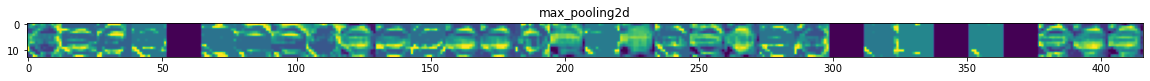

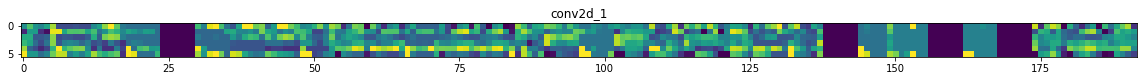

In [62]:
plot_feature_maps(baseline_model, img)

## Baseline - Kernel Size variations

In [26]:
# trying different kernel sizes
kernels = [5, 9, 13, 25]
models = [0] * (len(kernels))
mlops_config_kernels = models.copy()

In [27]:
# Generic parameters and call backs
from tensorflow.keras.callbacks import EarlyStopping

patience = 5

early_stopping = EarlyStopping (patience=patience, monitor='val_loss', mode='min', restore_best_weights=True)

### Training and Evaluation

In [31]:
history_kernels_kernels = [0] * (len(kernels))

for i in range(len(history_kernels_kernels)):
  # mlops
  start = timeit.default_timer()
  wandb.init(name='CNN_TS_baseline_kernels_b256_e100_' + str(i) , project='CNN_TS', config=mlops_config_kernels[i])
  # model fit
  history_kernels_kernels[i] = models[i].fit(
      train_generator,
      steps_per_epoch=mlops_config_kernels[i]['steps_per_epoch'],
      validation_data=val_generator,
      validation_steps=mlops_config_kernels[i]['validation_steps'],
      epochs=mlops_config_kernels[i]['epochs'],
      callbacks=[WandbCallback(),early_stopping])

  print('Model with filters {0:d}x{0:d}, epochs={1:d}, training accuracy={2:.5f}, validation loss={3:.5f}'.\
    format(mlops_config_kernels[i]['kernel_size'], mlops_config_kernels[i]['epochs'], max(history_kernels_kernels[i].history['acc']), max(history_kernels_kernels[i].history['val_loss'])))
  
  # mlops
  stop = timeit.default_timer()
  print('Time Elapsed: ', stop - start)
  wandb.log({'time-elapsed': stop - start})
  wandb.log({'training-accuracy': max(history_kernels_kernels[i].history['acc'])})
  wandb.log({'validation-loss': max(history_kernels_kernels[i].history['val_loss'])})
  wandb.log({'batch_size': mlops_config_kernels[i]['batch_size']})

  wandb.finish()


Epoch 1/100
5/5 [==============================] - 26s 6s/step - loss: 3.6421 - acc: 0.0484 - val_loss: 3.5100 - val_acc: 0.0924
Epoch 2/100
5/5 [==============================] - 22s 5s/step - loss: 3.4783 - acc: 0.0953 - val_loss: 3.3874 - val_acc: 0.1258
Epoch 3/100
5/5 [==============================] - 17s 4s/step - loss: 3.3637 - acc: 0.1734 - val_loss: 3.2642 - val_acc: 0.1918
Epoch 4/100
5/5 [==============================] - 24s 6s/step - loss: 3.2051 - acc: 0.2477 - val_loss: 3.0833 - val_acc: 0.2617
Epoch 5/100
5/5 [==============================] - 21s 5s/step - loss: 2.8908 - acc: 0.3336 - val_loss: 2.8804 - val_acc: 0.3176
Epoch 6/100
5/5 [==============================] - 18s 4s/step - loss: 2.6774 - acc: 0.3773 - val_loss: 2.6656 - val_acc: 0.3525
Epoch 7/100
5/5 [==============================] - 24s 6s/step - loss: 2.4120 - acc: 0.4187 - val_loss: 2.5136 - val_acc: 0.3693
Epoch 8/100
5/5 [==============================] - 23s 6s/step - loss: 2.3093 - acc: 0.4258 - val

acc,▁▁▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████
batch_size,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,██▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time-elapsed,▁
training-accuracy,▁
val_acc,▁▁▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████
val_loss,██▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
validation-loss,▁
acc,0.90938
batch_size,256


Epoch 1/100
5/5 [==============================] - 27s 6s/step - loss: 3.6096 - acc: 0.0578 - val_loss: 3.5658 - val_acc: 0.0621
Epoch 2/100
5/5 [==============================] - 19s 5s/step - loss: 3.4524 - acc: 0.1055 - val_loss: 3.4064 - val_acc: 0.1008
Epoch 3/100
5/5 [==============================] - 13s 3s/step - loss: 3.3486 - acc: 0.1617 - val_loss: 3.2916 - val_acc: 0.2166
Epoch 4/100
5/5 [==============================] - 13s 3s/step - loss: 3.1317 - acc: 0.2625 - val_loss: 3.0937 - val_acc: 0.2836
Epoch 5/100
5/5 [==============================] - 12s 3s/step - loss: 2.8914 - acc: 0.3531 - val_loss: 2.8697 - val_acc: 0.3260
Epoch 6/100
5/5 [==============================] - 11s 3s/step - loss: 2.6794 - acc: 0.3938 - val_loss: 2.5663 - val_acc: 0.3852
Epoch 7/100
5/5 [==============================] - 13s 3s/step - loss: 2.3327 - acc: 0.4539 - val_loss: 2.3569 - val_acc: 0.4213
Epoch 8/100
5/5 [==============================] - 11s 3s/step - loss: 2.1245 - acc: 0.4492 - val

acc,▁▁▂▃▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████████
batch_size,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▇▇▆▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time-elapsed,▁
training-accuracy,▁
val_acc,▁▁▂▃▃▄▅▅▅▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇█████████████
val_loss,██▇▇▆▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation-loss,▁
acc,0.91953
batch_size,256


Epoch 1/100
5/5 [==============================] - 24s 6s/step - loss: 3.6450 - acc: 0.0531 - val_loss: 3.5086 - val_acc: 0.0598
Epoch 2/100
5/5 [==============================] - 18s 4s/step - loss: 3.5031 - acc: 0.0664 - val_loss: 3.4853 - val_acc: 0.0602
Epoch 3/100
5/5 [==============================] - 23s 5s/step - loss: 3.4394 - acc: 0.1375 - val_loss: 3.3943 - val_acc: 0.1334
Epoch 4/100
5/5 [==============================] - 24s 6s/step - loss: 3.3370 - acc: 0.1859 - val_loss: 3.2924 - val_acc: 0.1820
Epoch 5/100
5/5 [==============================] - 26s 6s/step - loss: 3.1682 - acc: 0.2234 - val_loss: 3.1048 - val_acc: 0.2357
Epoch 6/100
5/5 [==============================] - 17s 4s/step - loss: 2.9829 - acc: 0.2711 - val_loss: 2.9445 - val_acc: 0.2441
Epoch 7/100
5/5 [==============================] - 12s 3s/step - loss: 2.8479 - acc: 0.3133 - val_loss: 2.6583 - val_acc: 0.3738
Epoch 8/100
5/5 [==============================] - 14s 3s/step - loss: 2.5913 - acc: 0.4055 - val

acc,▁▁▂▂▂▃▄▄▄▅▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇██▇▇███████████
batch_size,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,███▇▇▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
time-elapsed,▁
training-accuracy,▁
val_acc,▁▁▂▂▃▄▄▄▅▅▅▆▆▆▇▆▆▇▇▇▇▇▇▇█▇▇█████████████
val_loss,███▇▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation-loss,▁
acc,0.89375
batch_size,256


Epoch 1/100
5/5 [==============================] - 15s 4s/step - loss: 3.6980 - acc: 0.0344 - val_loss: 3.5989 - val_acc: 0.0566
Epoch 2/100
5/5 [==============================] - 15s 4s/step - loss: 3.5753 - acc: 0.0641 - val_loss: 3.5376 - val_acc: 0.0582
Epoch 3/100
5/5 [==============================] - 19s 5s/step - loss: 3.5152 - acc: 0.0562 - val_loss: 3.4854 - val_acc: 0.1119
Epoch 4/100
5/5 [==============================] - 23s 5s/step - loss: 3.4500 - acc: 0.1359 - val_loss: 3.4817 - val_acc: 0.1102
Epoch 5/100
5/5 [==============================] - 23s 6s/step - loss: 3.4525 - acc: 0.1086 - val_loss: 3.4150 - val_acc: 0.0797
Epoch 6/100
5/5 [==============================] - 23s 5s/step - loss: 3.3869 - acc: 0.1484 - val_loss: 3.3601 - val_acc: 0.1143
Epoch 7/100
5/5 [==============================] - 21s 5s/step - loss: 3.3199 - acc: 0.1586 - val_loss: 3.3005 - val_acc: 0.1541
Epoch 8/100
5/5 [==============================] - 19s 5s/step - loss: 3.2281 - acc: 0.1844 - val

acc,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇██████████
batch_size,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▇▇▇▇▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
time-elapsed,▁
training-accuracy,▁
val_acc,▁▁▂▂▂▂▃▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
val_loss,███▇▇▇▆▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁
validation-loss,▁
acc,0.78777
batch_size,256


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7465/2481331056.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7465/2481331056.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


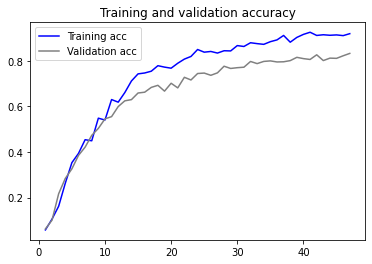

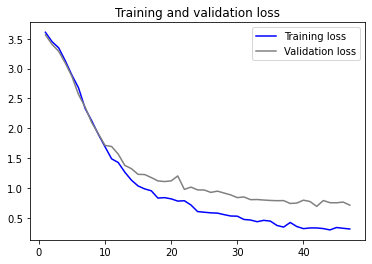

In [32]:
# From the results, we can see that the best kernel size is 9
# Checking the resutls
plot_results(history_kernels_kernels[1])

Confusion matrix, without normalization
[[ 0  5  3 ...  2  3  4]
 [ 5 54 40 ... 26 24 21]
 [ 4 34 30 ... 23 26 26]
 ...
 [ 3 27 23 ... 18 19 16]
 [ 1 21 37 ... 25 12 10]
 [ 3 26 14 ... 13 13 20]]


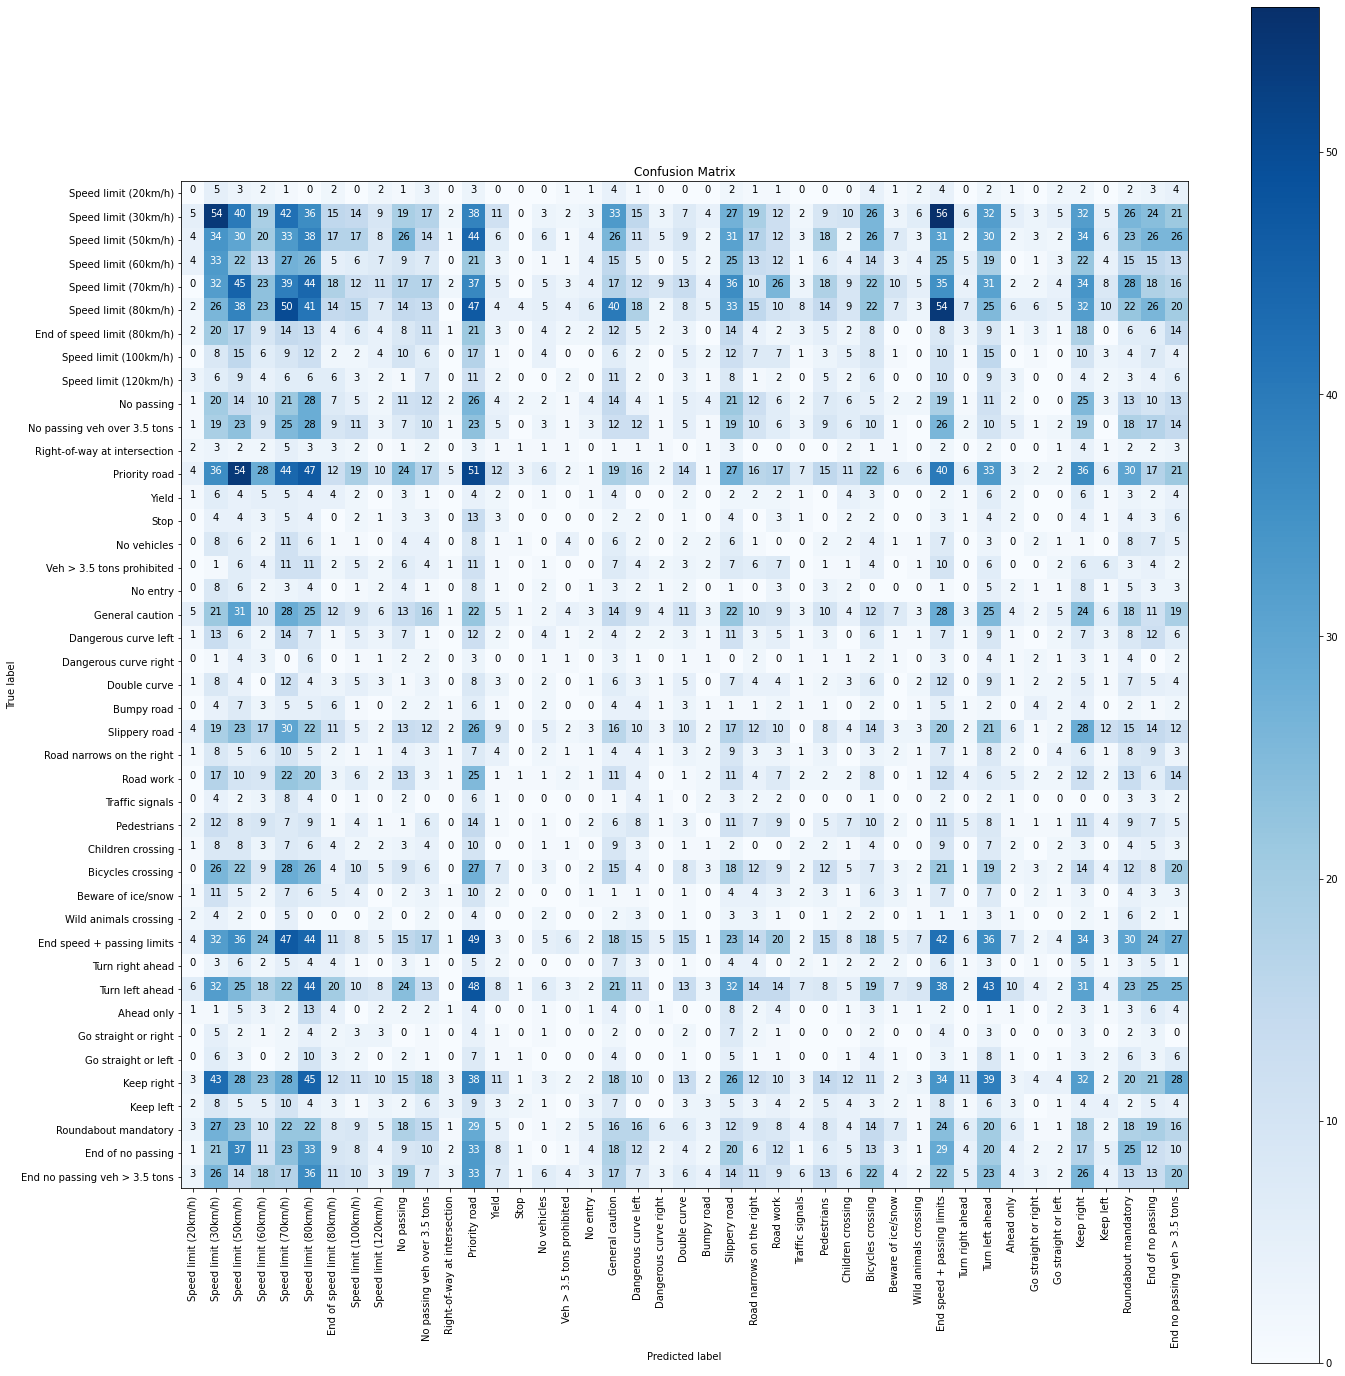

In [33]:
# predictions on Test data

Y_pred = models[1].predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

Shape before entering the conv layer: (1, 32, 32, 3)


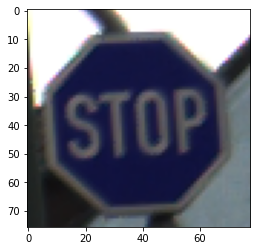

In [69]:
# plotting feature maps
# choosing a miss classified image
img = get_input_img(14,img_width, img_height, 30, 'Test')
print ('Shape before entering the conv layer:', img.shape)

(1, 12, 12, 32)
(1, 10, 10, 32)
(1, 5, 5, 32)
(1, 800)
(1, 500)
(1, 43)


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7465/2990367024.py:120: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


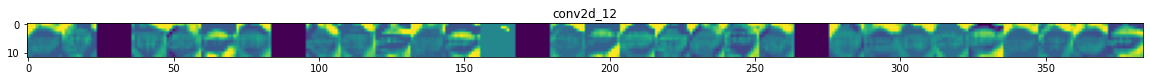

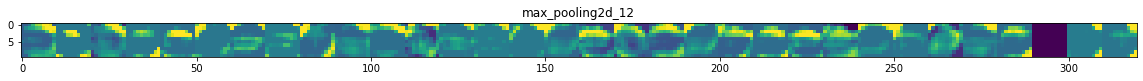

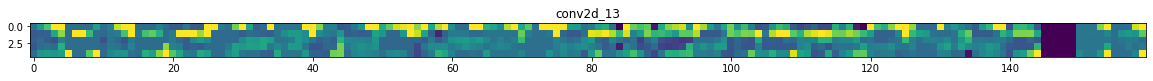

In [70]:
plot_feature_maps(models[1], img)

## 7 layer model

Refference: Masci, et al "A committee of neural networks for traffic sign classification" [1]

In [40]:
masci_model = Sequential()
# Refference: DLNN lecture week 6
masci_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
masci_model.add(Conv2D(filters=32, kernel_size = (4, 4), strides = (1,1), activation = relu, padding = 'valid'))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
masci_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
# MLP - input layer
masci_model.add(Flatten())
# MLP - hidden layer
masci_model.add(Dense(units=200, activation=relu))
# MLP - output layer
masci_model.add(Dense(units=43, activation=softmax))

# Check built model:
masci_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 12, 12, 32)        16416     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 4, 4, 32)          9248      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 2, 2, 32)        

In [41]:
from tensorflow.keras import optimizers 

masci_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [42]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num
}

mlops_config['steps_per_epoch'] = 5
mlops_config['epochs'] = 100
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['metrics'] = ['acc']

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 5
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [44]:
# MLOps init and callback
wandb.init(name='CNN_TS_masci_b256_e100' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_masci_model = masci_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

Epoch 1/100
5/5 [==============================] - 22s 5s/step - loss: 3.6971 - acc: 0.0461 - val_loss: 3.5885 - val_acc: 0.0531
Epoch 2/100
5/5 [==============================] - 14s 3s/step - loss: 3.5636 - acc: 0.0617 - val_loss: 3.5195 - val_acc: 0.0604
Epoch 3/100
5/5 [==============================] - 13s 3s/step - loss: 3.4984 - acc: 0.0547 - val_loss: 3.4970 - val_acc: 0.0684
Epoch 4/100
5/5 [==============================] - 11s 2s/step - loss: 3.4882 - acc: 0.0914 - val_loss: 3.4632 - val_acc: 0.0559
Epoch 5/100
5/5 [==============================] - 12s 3s/step - loss: 3.4545 - acc: 0.0898 - val_loss: 3.4229 - val_acc: 0.0963
Epoch 6/100
5/5 [==============================] - 11s 3s/step - loss: 3.3563 - acc: 0.1211 - val_loss: 3.3666 - val_acc: 0.0971
Epoch 7/100
5/5 [==============================] - 12s 3s/step - loss: 3.2518 - acc: 0.1461 - val_loss: 3.2881 - val_acc: 0.1629
Epoch 8/100
5/5 [==============================] - 10s 2s/step - loss: 3.1682 - acc: 0.2070 - val

acc,▁▁▁▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,███▇▇▇▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
time-elapsed,▁
val_acc,▁▁▁▁▃▂▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇█████████
val_loss,███▇▇▇▆▆▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.87031
best_epoch,71
best_val_loss,1.07162
epoch,76
loss,0.44728


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7465/2481331056.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7465/2481331056.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


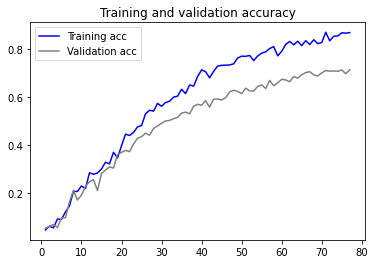

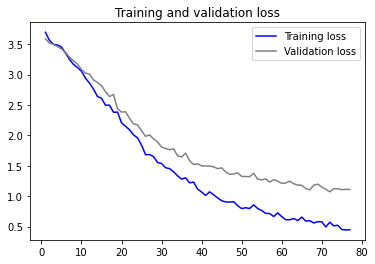

In [45]:
plot_results(history_masci_model)

Confusion matrix, without normalization
[[ 1  2  2 ...  1  3  3]
 [ 0 27 36 ... 26 28 26]
 [ 2 29 40 ... 19 16 26]
 ...
 [ 2 29 31 ... 10  9 12]
 [ 3 20 22 ... 14  8 23]
 [ 1 31 20 ... 19 12 20]]


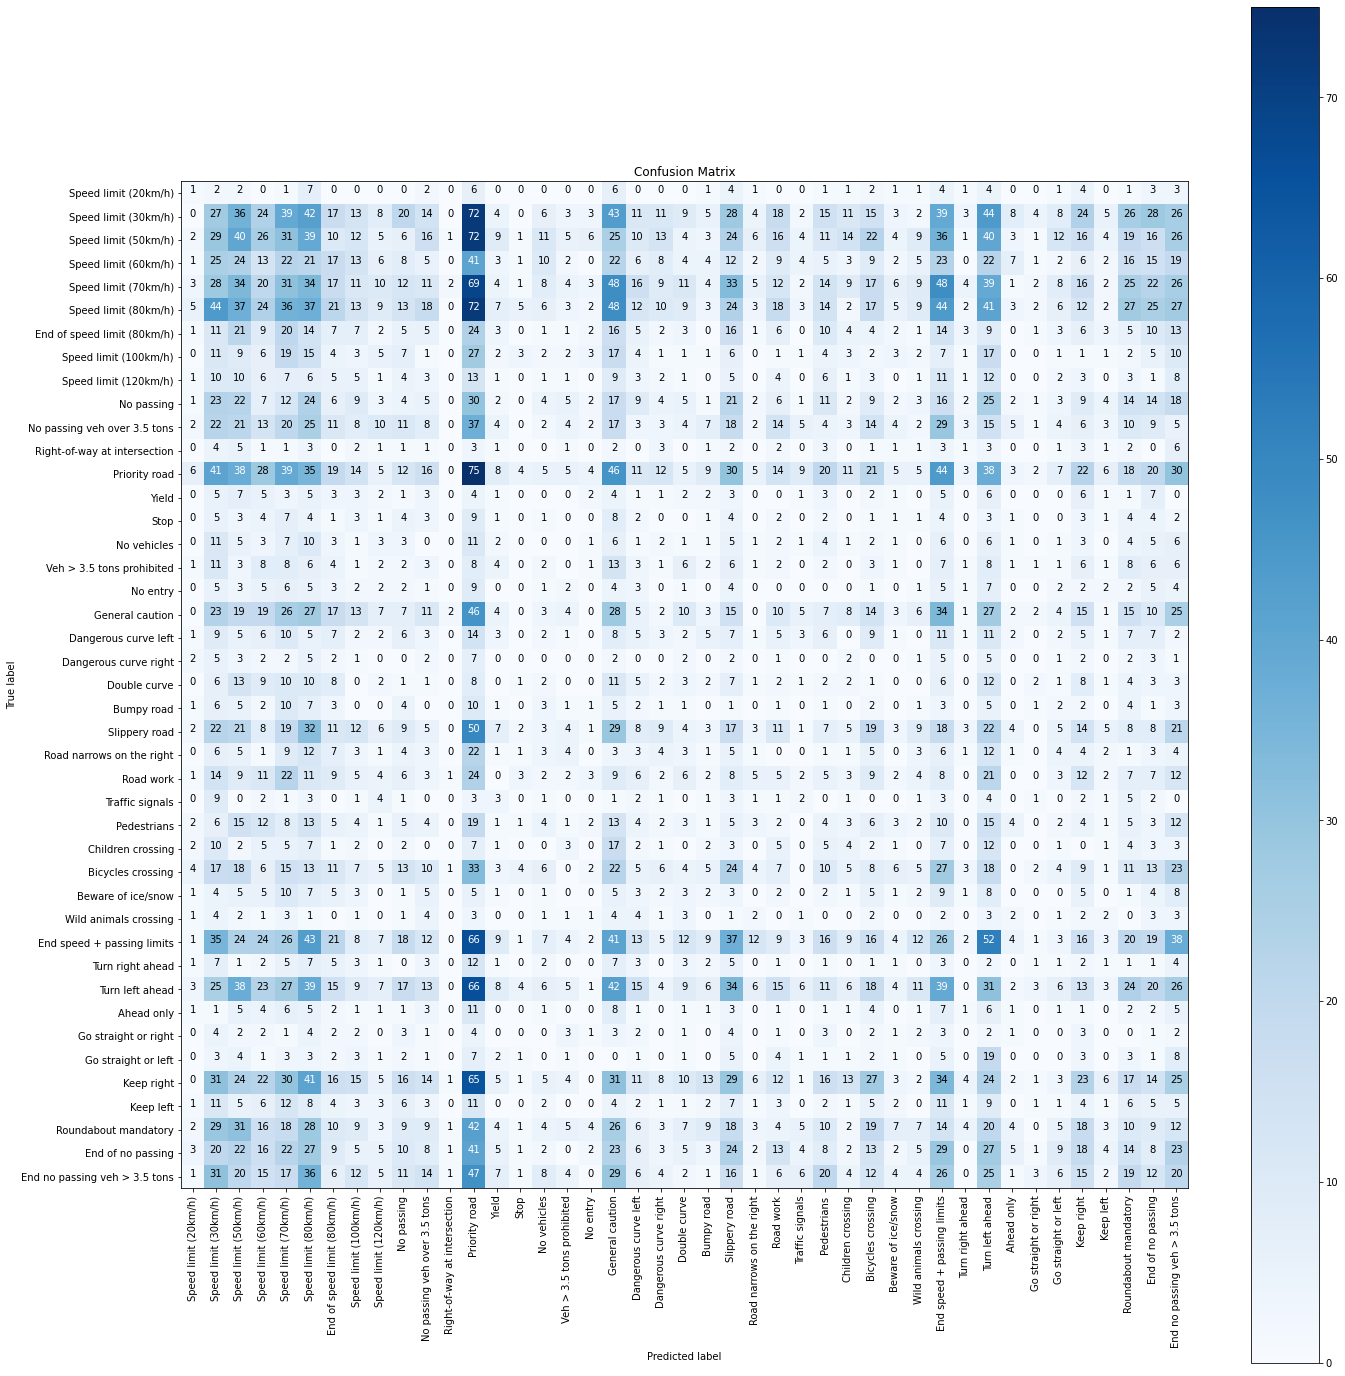

In [46]:
# predictions on Test data

Y_pred = masci_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

Shape before entering the conv layer: (1, 32, 32, 3)


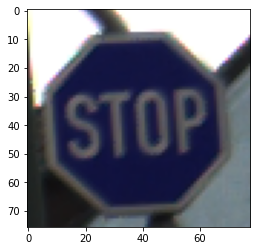

In [67]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 30, 'Test')
print ('Shape before entering the conv layer:', img.shape)

(1, 15, 15, 32)
(1, 12, 12, 32)
(1, 6, 6, 32)
(1, 4, 4, 32)
(1, 2, 2, 32)
(1, 128)
(1, 200)
(1, 43)


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7465/2990367024.py:120: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


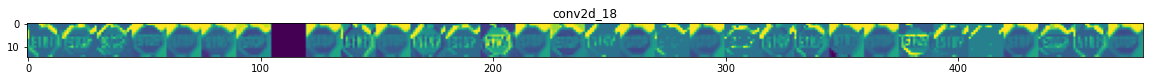

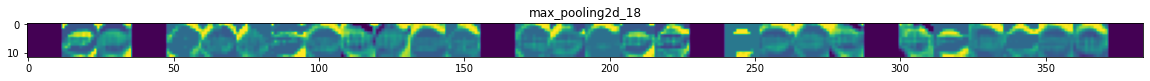

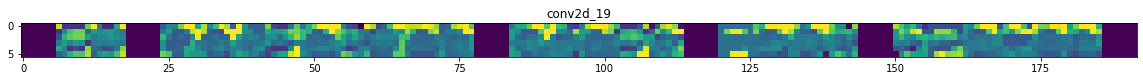

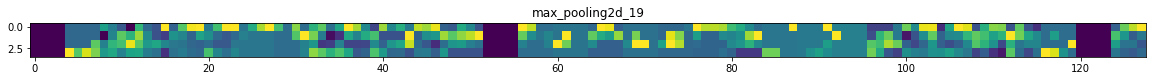

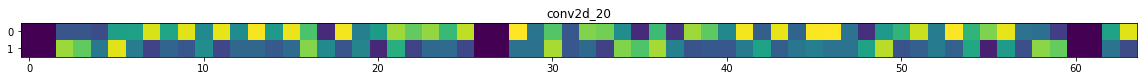

In [68]:
plot_feature_maps(masci_model, img)


conv2d_18 <keras.engine.functional.Functional object at 0x17ceaca60>
32


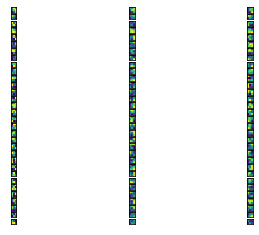

conv2d_19 [[[[0.48780724 0.35038272 0.3021891  0.5578593  0.58409864 0.38499323
    0.7366634  0.26961908 0.6265599  0.23008879 0.43469167 0.5013133
    0.8067102  0.19591434 0.53942823 0.67033017 0.614705   0.467871
    0.35496435 0.31745934 0.41226697 0.4363541  0.6381835  0.41778922
    0.41902944 0.2630077  0.49527037 0.68386716 0.26083052 0.5720835
    0.71652603 0.5773401 ]
   [0.4874344  0.7199017  0.2859479  0.7838637  0.5976528  0.63579565
    0.43127024 0.5082246  0.40823254 0.1780024  0.62771773 0.7576049
    0.7286259  0.70499814 0.45085824 0.6494358  0.5965669  0.7122762
    0.4731437  0.6985276  0.63595325 0.7039783  0.27030057 0.50605756
    0.78079444 0.38322845 0.71370184 0.65246195 0.62371874 0.46198642
    0.26784906 0.45177507]
   [0.2581293  0.4871642  0.3316754  0.42967352 0.576918   0.7783342
    0.44150245 0.39822754 0.24275778 0.15969184 0.8335825  0.69119304
    0.66921735 0.32014713 0.42405784 0.43523586 0.5153976  0.40216026
    0.29728538 0.3913942  0.34366

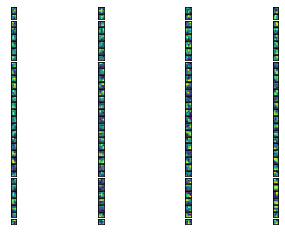

conv2d_20 [[[[0.6316473  0.5690341  0.6464331  ... 0.44459105 0.47898373
    0.5670557 ]
   [0.59796816 0.56284684 0.5648186  ... 0.5941549  0.72148514
    0.48081258]
   [0.5886617  0.5664452  0.57364494 ... 0.4294311  0.6571521
    0.3998901 ]
   ...
   [0.64328545 0.6075614  0.49345386 ... 0.52241766 0.55747956
    0.44160408]
   [0.54143125 0.6204468  0.43204904 ... 0.5203446  0.54776853
    0.5409795 ]
   [0.5963162  0.60593605 0.4076885  ... 0.4744689  0.47933432
    0.48117745]]

  [[0.5314592  0.58539945 0.44557974 ... 0.3581523  0.8689031
    0.49732745]
   [0.4614278  0.5524927  0.5205743  ... 0.5774415  0.6028418
    0.59820414]
   [0.638281   0.57971627 0.54464656 ... 0.4769443  0.6409923
    0.569155  ]
   ...
   [0.47549638 0.5875913  0.49453035 ... 0.55725366 0.5763717
    0.4901779 ]
   [0.45337662 0.50375736 0.5905311  ... 0.47738925 0.77183604
    0.57780695]
   [0.46721566 0.41551304 0.42932346 ... 0.4810051  0.4903221
    0.56930286]]

  [[0.4686303  0.5902614  0.49

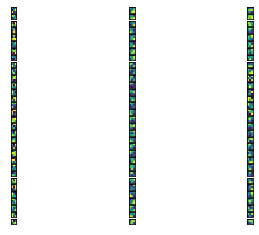

In [57]:
#Iterate thru all the layers of the model
for layer in masci_model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name, filters)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

# Next Steps
- Plot the outputs of the several conv layers
- Check with different architectures:
  - See the used on the papers (masci done)
    - 2nd paper pending  - PA
    - consider a dropout layer with higher kernel values

- Check data augementation - PA
- Precision and recall metrics - JG
- Feature maps understanding  - AT / FB
- SHAP explainder - AT / FB

- Improve the acc/val loss graphs to plot multiple model curves

If time allows:
 - Check wandb sweep
 - consider different optimizers
 - consider different loss functions


# Batch Size and Epochs
https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/


# 